# First pass analysis of line/loop data

<ul>
    <li> Analyse correct sequence lengths. </li>
    <li> Do reaction times </li>
    <li> Analyse as a function of distance from reward </li>
    <li> Try to fit RL model to these data </li> 
    
</ul>

<b> WHY IS THERE A DIFFERENCE BETWEEN REW_LIST AND DAT_DICT['STATE'] </b>

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn
import scipy.stats as stt
seaborn.set(font_scale=1.5,style='ticks')
import os
import re
import sys
import itertools
import functools
import networkx as nx
from datetime import date, timedelta
from datetime import datetime

sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master")
sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master\packages")
sys.path.append("/Users/yves/Documents/Code/line_loop/packages/")

In [2]:
import mouse_poker as mpk

# Defined functions 

In [3]:
poke_pos = [ [149,0],
         [68,19],[231,19],
       [0,62],[149,62],[298,62],
         [68,105],[231,105],
              [149,124]]

In [4]:
from mouse_poker.navi import *

In [5]:
def get_performance(state_seq,rew_list,port_seq,forced_seq,rew_indices,map_poke_to_state,minNrew=5,set_rew_indices=None,firstOnly=False):
    """ Get fraction correct in each state"""
    used_states = sorted([i[1] for i in map_poke_to_state.args[0]])
    if set_rew_indices is None: set_rew_indices=used_states
    perf = np.zeros([9,9])
    perf_ctr = np.zeros([9,9])
    rew_hist = []
    all_rew_loc = []
    for rew_ctr,(st,nd) in enumerate(zip(np.where(rew_list)[0][:-2],np.where(rew_list)[0][1:-1])):
        rew_loc = state_seq[nd]
        if (rew_loc in set_rew_indices):
            c_rew_index = rew_indices.index(port_seq[nd])
            all_rew_loc.append(rew_loc)
            if not rew_hist:
                rew_hist.append(rew_loc)
            elif rew_loc==rew_hist[-1]:
                rew_hist.append(rew_loc)
            else:
                rew_hist = []

            has_visited= []
            if len(rew_hist)>minNrew:

                for pk_ctr in range(st+1,nd+1):
                    if not forced_seq[pk_ctr]:
                        
                        d0 = np.abs(state_seq[pk_ctr]-rew_loc)
                        d1 = np.abs(state_seq[pk_ctr+1]-rew_loc)

                        state = state_seq[pk_ctr]
                        rewarded = rew_list[pk_ctr]  #if it is rewarded. Offset by 1

                        if state not in has_visited:
                            if rewarded:
                                perf[state,rew_loc] += 1
                                perf_ctr[state,rew_loc] += 1

                            elif d1<d0:
                                perf[state,rew_loc] += 1
                                perf_ctr[state,rew_loc] += 1
                            else:
                                perf[state,rew_loc] += 0
                                perf_ctr[state,rew_loc] += 1
                            if firstOnly: has_visited.append(state)
    
    for i in np.unique(rew_hist):
        perf[i,i] = np.nan

    return perf, perf_ctr

# Actual code to run stuff 

In [24]:
#print(day_df['filepath'].values[ix])
#f = open("/Users/yves/Documents/behavior_data/line_loop_cohort_1/line_loop_batch_4_RUNNAVI/'456675_3'-2020-12-09-094620.txt",'r')
#f = open("/Volumes/hpc_dat/pycontrol/data/line_loop_batch_4_RUNNAVI/'456675_3'-2021-02-12-121633.txt",'r')
#f = open("/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'460175_10'-2021-03-01-110337.txt",'r')
#f = open("C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI/'456675_10'-2021-03-04-105905.txt",'r')
##f =open("C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI_toLOOP/",'r')
#f = open("/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI_toLOOP/'460175_10'-2021-03-04-154221.txt")
f = open("C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI_males/'456674_30'-2021-03-15-114101.txt",'r')

lines =f.readlines()
experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)

print("rewards_received: {:d}".format(nRews))
print('task_nr:{:.0f}'.format(int(task_nr)))

rewards_received: 282
task_nr:1


In [25]:
poke_to_state_map,full_pkst_map = get_poke_to_state_map(lines)
used_states = sorted([i[1] for i in full_pkst_map])
used_pokes = ([i[0] for i in full_pkst_map])

map_poke_to_state = functools.partial(map_poke_to_state_fun,full_pkst_map)
map_state_to_poke = functools.partial(map_state_to_poke_fun,full_pkst_map)

#rew_indices = [0,3,5,8]
rew_indices = np.unique([eval(re.findall('REWARD LOCATIONS(\[.*\])',l)[0]) for l in lines if re.findall('REWARD LOCATIONS(\[.*\])',l)][0]).tolist()


In [26]:
state_seq = [i[0] for i in dat_dict['state']]
poke_seq = [map_state_to_poke(i) for i in state_seq]
#dat_dict['rews']

In [27]:
state_seq, rew_list, port_seq,forced_seq = extract_navi_dat(lines)
perf,perf_ctr = get_performance(state_seq,rew_list,port_seq,forced_seq,rew_indices,map_poke_to_state,minNrew=5)
fc = perf/perf_ctr
#fc[np.isnan(fc)] = 1
print(np.nanmean(fc))

0.7669169728884976


<ipython-input-27-334b5c5cf0c8>:3: RuntimeWarning: invalid value encountered in true_divide
  fc = perf/perf_ctr


In [28]:
fc

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.82474227, 1.        ,        nan, 1.        ,
        1.        ,        nan,        nan,        nan],
       [       nan, 0.81632653, 1.        ,        nan, 0.59183673,
        0.50909091, 0.59459459,        nan,        nan],
       [       nan, 0.66666667, 0.9       ,        nan, 0.82978723,
        0.63414634, 0.56410256,        nan,        nan],
       [       nan, 0.72277228, 0.63636364,        nan, 0.81428571,
        0.66666667, 0.62068966,        nan,        nan],
       [       nan, 0.48979592, 0.41463415,        nan, 0.69230769,
        0.88461538, 0.83333333,        nan,        nan],
       [       nan, 1.        , 1.        ,        nan,        nan,
        1.        ,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],


In [29]:
perf

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 80., 10.,  0., 12.,  5.,  0.,  0.,  0.],
       [ 0., 80., 28.,  0., 29., 28., 22.,  0.,  0.],
       [ 0., 68., 18.,  0., 39., 26., 22.,  0.,  0.],
       [ 0., 73., 14.,  0., 57., 20., 18.,  0.,  0.],
       [ 0., 48., 17.,  0., 18., 23., 20.,  0.,  0.],
       [ 0., 10.,  1.,  0.,  0.,  2., nan,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

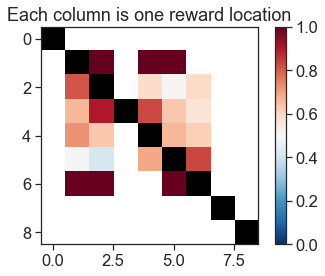

In [30]:
plt.title('Each column is one reward location')
rew_diag_mtx = np.dstack([np.eye(perf.shape[0])*-1 + 1]*3 + [np.eye(perf.shape[0])])
#fcplot = (perf/perf_ctr)
np.fill_diagonal(fc,np.nan)
plt.imshow(rew_diag_mtx,cmap='Greys')
plt.imshow(fc,vmin=0,vmax=1,cmap='RdBu_r')
#plt.xlim(.5,6.5); plt.ylim(6.5,.5)
plt.colorbar()

# Run as batch analysis the above 

In [13]:
now = datetime.now()

In [16]:
ROOT = '/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'
fs = os.listdir(ROOT)
res_dict = {}
minNRew = 15
today = datetime.now()
for f_ in fs:
        
    fpath = os.path.join(ROOT,f_)
    if os.path.isfile(fpath):
        subject = eval(re.findall("('.*')",f_)[0])
        #print(subject)

        t1_ = re.findall(r'(202.*)-[0-9]{6}.txt',f_)[0]
        t1_ = datetime.strptime(t1_,'%Y-%m-%d')
        
        if (now - t1_).days<=15:
            f = open(fpath,'r')

            lines =f.readlines()
            experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
            dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)
            subject = subject + '_' + str(task_nr)
            print(task_nr,fpath)
            if nRews>20:

                poke_to_state_map,full_pkst_map = get_poke_to_state_map(lines)
                used_states = sorted([i[1] for i in full_pkst_map])
                used_pokes = ([i[0] for i in full_pkst_map])

                map_poke_to_state = functools.partial(map_poke_to_state_fun,full_pkst_map)
                map_state_to_poke = functools.partial(map_state_to_poke_fun,full_pkst_map)

                #rew_indices = [0,3,5,8]
                rew_indices = np.unique([eval(re.findall('REWARD LOCATIONS(\[.*\])',l)[0]) for l in lines if re.findall('REWARD LOCATIONS(\[.*\])',l)][0]).tolist()
                state_seq, rew_list, port_seq,forced_seq = extract_navi_dat(lines)
                perf,perf_ctr = get_performance(state_seq,rew_list,port_seq,forced_seq,rew_indices,map_poke_to_state,minNrew=5)

                if subject not in res_dict.keys():
                    res_dict[subject] = [[perf,perf_ctr]]
                else:
                    res_dict[subject].append([perf,perf_ctr])


1 /Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'456675_10'-2021-03-02-132000.txt
2 /Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'460175_10'-2021-03-03-105405.txt
1 /Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'456675_10'-2021-03-05-110006.txt
2 /Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'460175_10'-2021-03-01-110337.txt
2 /Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'460175_10'-2021-03-02-142443.txt
1 /Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'456675_10'-2021-03-05-111657.txt
1 /Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'456675_10'-2021-03-05-105811.txt
1 /Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'460175_10'-2021-03-05-111657.txt
1 /Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'460175_10'-2021-03-05-105811.txt
2 /Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/'456675_10'-2021-03-01-110337.txt
2 /Users/yves/Documents/beh_da

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


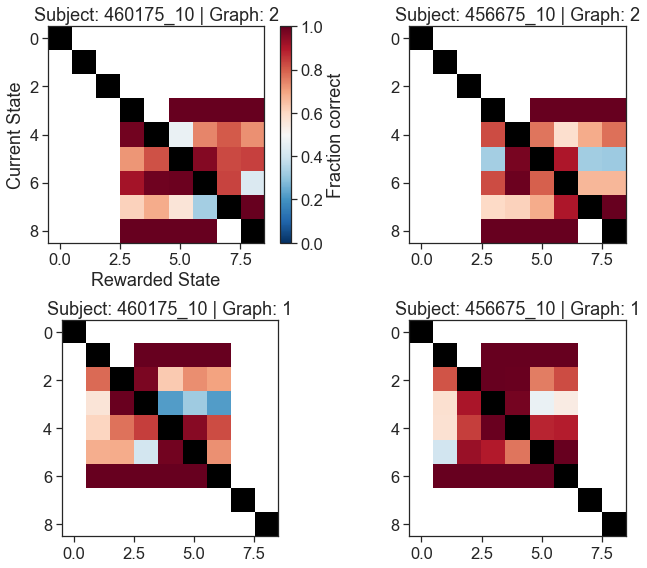

In [31]:
plt.figure(figsize=(10,8))
for ctr,subject in enumerate(res_dict.keys()):
    
    plt.subplot(2,2,ctr+1)
    plt.title("Subject: {} | Graph: {}".format(subject[:-2],subject[-1]))
    allp = np.nansum([i[0] for i in res_dict[subject]],axis=0)
    allp_ctr = np.nansum([i[1] for i in res_dict[subject]],axis=0)
    fc = (allp/allp_ctr)
    np.fill_diagonal(fc,np.nan)
    plt.imshow(np.dstack([np.eye(perf.shape[0])*-1 + 1]*3 + [np.eye(perf.shape[0])]),cmap='Greys')
    plt.imshow(fc,vmin=0,vmax=1,cmap='RdBu_r')
    
    if ctr==0:
        plt.xlabel("Rewarded State")
        plt.ylabel("Current State")
        cbar = plt.colorbar()
        cbar.set_label("Fraction correct")

plt.tight_layout()

# Other

In [18]:
st = np.min(np.where(np.nansum(perf,axis=1))[0]) - 1
nd = np.max((np.where(np.nansum(perf,axis=1))[0])) + 1


#these are the pokes used for reward in this session
used_rews = np.array([np.where(np.isnan(perf[:,i]))[0] for i in np.where(np.nansum(perf,axis=0))[0]]).flatten()
used_rew_cols = np.where(np.nansum(perf,axis=0))[0]

In [19]:
ix = used_rew_cols[0]
c_rew_index = ix

#good_edges = [[map_state_to_poke(0),map_state_to_poke(1)],
#              [map_state_to_poke(8),map_state_to_poke(7)]]
bad_edges = []
good_edges = []
for s in range(st-1,nd+1):
    if s!=c_rew_index and s in used_states:
        d1 = np.abs(c_rew_index-(s+1))  #distances of state above to reward
        d2 = np.abs(c_rew_index-(s-1))  #distance of state below to reward
        min_ = np.argmin([d1,d2])
        max_ = np.argmax([d1,d2])
        
        if [s+1,s-1][min_] in used_states:
            good_edges.append([s,[s+1,s-1][min_]])  #good edges in terms of pokes
        
        if [s+1,s-1][max_] in used_states:
            bad_edges.append([s,[s+1,s-1][max_]])   #bad edges in terms of pokes

In [20]:
map_state_to_poke(ix)

4

In [21]:
used_rew_cols

array([4, 7])

In [22]:
#rew_indices = [0,1,4,5]

In [23]:
st = used_states[0]-1#np.min(np.where(np.nansum(perf,axis=1))[0]) - 1
nd = used_states[1]+1#np.max((np.where(np.nansum(perf,axis=1))[0])) + 1


#these are the pokes used for reward in this session
used_rews = np.array([np.where(np.isnan(perf[:,i]))[0] for i in np.where(np.nansum(perf,axis=0))[0]]).flatten()
used_rew_cols = np.where(np.nansum(perf,axis=0))[0]

In [24]:
st

2

In [25]:
nd

5

In [29]:
used_rew_cols

array([4, 7])

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


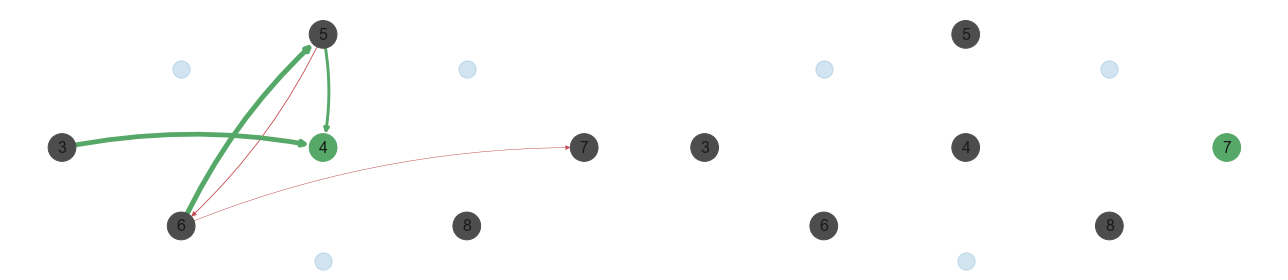

In [30]:
plt.figure(figsize=(18,4))
ctr = 1
for ix in used_rew_cols:
    plt.subplot(1,len(used_rew_cols),ctr)

    c_rew_index = ix  #this is correct, used_rews here are in terms of states

    bad_edges = []
    good_edges = []
    same_edges = []
    good_edges = [[map_state_to_poke(used_states[0]),map_state_to_poke(used_states[1])],
                  [map_state_to_poke(used_states[-1]),map_state_to_poke(used_states[-2])]]

    for s in range(st-2,nd+2):
        if s!=c_rew_index and s in used_states:
            su = s+1 #state_up
            sd = s-1 #state_down
            if lineloop=='loop': 
                if su==used_states[-1]+1:
                    su= used_states[0]
                if sd==used_states[0]-1:
                    sd = used_states[-1]
            d1 = np.abs(c_rew_index-(su))  #distances of state above to reward
            d2 = np.abs(c_rew_index-(sd))  #distance of state below to reward
            
            min_ = np.argmin([d1,d2])
            max_ = np.argmax([d1,d2])

            mn_ = [su,sd][min_]; mx_ = [su,sd][max_]

            if d1==d2:
                if mn_ in used_states:
                    same_edges.append([map_state_to_poke(s),map_state_to_poke(mn_)])

                if mx_ in used_states:
                    same_edges.append([map_state_to_poke(s),map_state_to_poke(mx_)])
            else:
                
                if mn_ in used_states:
                    good_edges.append([map_state_to_poke(s),map_state_to_poke(mn_)])

                if mx_ in used_states:
                    bad_edges.append([map_state_to_poke(s),map_state_to_poke(mx_)])

        

    pos = np.array([1,-1])*poke_pos
    G0 = nx.DiGraph()
    G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos)
    nx.draw(G0,pos=pos,alpha=.2)
    G = nx.DiGraph()
    G.add_nodes_from(sorted(used_pokes))
    weights = []
    
    rew_col = fc[:,ix]
    
    for e in good_edges:
        G.add_edge(e[0],e[1],weight=rew_col[map_poke_to_state(e[0])],color='g')
    for e in bad_edges:
        G.add_edge(e[0],e[1],weight=1-rew_col[map_poke_to_state(e[0])],color='r')
    for e in same_edges:
        print(ctr,map_poke_to_state(e[0]),map_poke_to_state(e[1]))
        G.add_edge(e[0],e[1],weight=rew_col[map_poke_to_state(e[0])],color='.3')

    weights = nx.get_edge_attributes(G,'weight')
    colors = nx.get_edge_attributes(G,'color')
    node_colors = ['.3' for _ in range(len(used_states))]
    
    node_colors[list(G.nodes).index(map_state_to_poke(c_rew_index))] = 'g'
    #node_colors[0] = 'g'
    nx.draw(G,
        pos=pos,
            width=(10**(np.array(list(weights.values()))))/2,
            edge_color=np.array(list(colors.values())),
            connectionstyle="arc3,rad=-0.1",
            node_color=node_colors,
            node_size=768,)
    
    labels = {i:j for i,j in zip(sorted(used_pokes),[map_poke_to_state(i) for i in sorted(used_pokes)])}
    nx.draw_networkx_labels(G, pos, labels, font_size=16)
    #print([map_poke_to_state(i) for j in same_edges for i in j])
    #print(G.node)
    ctr += 1
plt.tight_layout()
#plt.savefig("/Users/yves/Debsktop/tpf/navi_decisions.svg")
#plt.savefig("/Users/yves/Desktop/tpf/navi_decisions.png",dpi=300)


In [28]:
ROOT = '/Users/yves/Documents/behavior_data/line_loop_cohort_1/line_loop_batch_4_RUNNAVI/'
fs = sorted([os.path.join(ROOT,i) for i in os.listdir(ROOT) if '.txt' in i])
perf_hist = []
all_fc  = []
all_perf = np.zeros([9,4])
all_ctr = np.zeros([9,4])
for f_ in fs[:-1]:
    try:
        f = open(f_,'r')
        lines =f.readlines()
        experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
        dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)

        #poke_to_state_map = get_poke_to_state_map(lines)
        rew_indices = [0,3,5,8]
        perf,perf_ctr = get_performance(dat_dict,poke_to_state_map,rew_indices,lines,minNrew=20)

        fc = perf/perf_ctr
        all_perf += perf
        all_ctr += perf_ctr
        all_fc.append(fc)
        perf_hist.append(np.nanmean(fc))
    except:
        pass